# UFSM
## Engenharia Acústica 
## Processamento Digital de Sinais II
### Trabalho Integrado: rotina de medição

In [1]:
# Carregando as bibliotecas que utilizaremos
import pytta
from scipy.io import wavfile as wf
import copy as cp
import numpy as np

#### Organização dos dados medidos
 
O tipo de dado Struct, do MATLAB, funciona de forma semelhante ao Dictionary do Python. Vamos organizar as variáveis com dicionários dentro de dicionários.

Sugiro que os dados sejam organizados nos seguintes níveis de informação e sequência:
1. Configuração fonte receptor; e.g. S1R1;
2. Sinal de excitação: sweep, música ou fala;
3. Sinal gravado: biauricular, monofônico

É notável que no momento da medição os dados não serão adquiridos nessa sequência. Uma parte do trabalho da nossa rotina de medição é pegar os dados medidos na última tomada e inseri-los no lugar correto do nosso dicionário de medição. Pois a cada tomada o número de posições medidas de receptor  mudará, como já vimos na matriz de teste (e.g. tomada 1 com S1R1 - biauricular, S1R2 - centro da cabeça - e S1R3 - centro do cabeça; tomada 'n' somente com S2R5 - biauricular).

#### Exemplo de dicionário de medição

In [6]:
fileName = 'Piano Over the rainbow Mic2  SHORT.wav'

hc = pytta.read_wav(fileName)   # Cria SignalObj hc (head center) 
                                # como um sinal qualquer para demonstração

binaural = pytta.merge(hc,hc)   # Copia objeto hd para novo objeto binaural. Caso fizessemos binaural = hc as
                               # alterações em binaural afetariam hc
    
SnRn_music = {'binaural':binaural,'hc':hc}
    
SnRn = {'sweep':{},'music':SnRn_music,'speech':{}}  # Cria um dicionário referente as medições de uma configuração 
                                            # fonte-receptor qualquer

measurement = {} # Cria o dicionário vazio que conterá todos os níveis de informação do nosso dia de medição


None
criando signalobj do merge
None


In [ ]:
RecMeasure = pytta.generate.measurement(kind = 'rec',
                                        lengthDomain = 'samples',
                                        fftDegree = 14,
                                        samplingRate = pytta.default.samplingRate,
                                        freqMin = 20,
                                        freqMax = 20000,
                                        device = [0,1],
                                        inChannel = [1],
                                        comment = 'RecMeasure test')

In [ ]:
hc.plot_time()

In [ ]:
dir(pytta.classes.np.array([]))

In [ ]:
s1 = pytta.SignalObj(np.array([[1,2,3,5],[1,2,3,5]]),'time',samplingRate=44100)
s2 = pytta.SignalObj(np.array([1,2,3,6]),'time',samplingRate=44100)

In [ ]:
pytta.merge(s1,s2)

In [ ]:
timeSignal1 = np.array([s1.timeSignal])
timeSignal2 = np.array([s2.timeSignal])

In [ ]:
timeSignal1 = timeSignal1.T
timeSignal2 = timeSignal2.T

In [ ]:
c = np.hstack((timeSignal1,timeSignal2))

In [ ]:
c[:,0]

In [ ]:
c[:,1]

In [ ]:
np.array([s1.timeSignal]).T

In [ ]:
c.shape

In [ ]:
dir(c)

In [3]:
binaural.play()

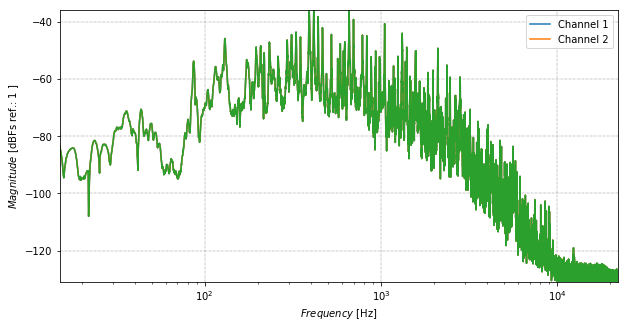

In [4]:
binaural.plot_freq()